 <span style="color: purple; font-weight: bold; font-size:26px"> Check if any models performs better than the naive classifier </span>


Let's start by importing some libs

In [2]:
# data analysis
import pandas as pd
import numpy as np
import random

# visualisations
import seaborn 
import matplotlib.pyplot as plt
%matplotlib inline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import pickle # for saving the model

# preprocesing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest

# just out of curiosity
import time


Now, let's define some helper functions!


In [3]:
# let's define some helper functions:

def plot_models_acc(dict, naive_classifier):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n]['accuracy'] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    # add a horizontal line at naive_classfier
    plt.axhline(y=naive_classifier, color='r', linestyle='-', label='Naive Classifier')
    plt.legend(loc='lower right')
    
    plt.show()

    
# checking the distribution of the features :)
def feature_dist(dataframe):
    col_num = len(dataframe.columns)
    from_to_ind = [(i, i+6) for i in range(0, col_num, 6)]

    for i, j in from_to_ind:
        if j >= col_num:
            if col_num - 1 == i:
                dataframe.iloc[:, i].hist(figsize=(11,11))
            else:
                dataframe.iloc[:, i:col_num-1].hist(layout=(1,col_num - 1 - i), figsize=(11,11))
        else:
            dataframe.iloc[:, i:j].hist(layout=(2,3), figsize=(11,11))
            
            
def conf_mat(grid_search: GridSearchCV, Y_test):
    # construction confusion matrix
    outcome_class_labels = ['Red', 'Draw', 'No contest', 'Blue']
    cm = confusion_matrix(
        Y_test, 
        grid_search.predict(X_test),
        labels = outcome_class_labels
    )

    # create heatmap
    seaborn.heatmap(
        cm, 
        annot=True, 
        cmap='Blues', 
        xticklabels=outcome_class_labels,
        yticklabels=outcome_class_labels,
        fmt='d')

    # add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return cm

### Importing data
Let's import our data now. It will most likely change, since the older data seems to be a little weird. For example, most of the winners are on the red side, most of some data is missing etc.

In [4]:
data = pd.read_excel("./UFCdata/test_final.xlsx")
data = data.sort_values('Event_Date', ascending=True).reset_index(drop=True)
data = data.replace(['--', '---'], pd.NA)[2500:] # also just for now, but starting from 3000's row is a nice tradeoff
# between a lower naive classifier accuracy and the completeness of the data
data = data.dropna() # absolutely not final!!!!!!!! xD


In [ ]:
data.info()

In [22]:
data.describe()

,Column1,Unnamed: 0,R_Height_cm,R_Weight_kg,R_Reach,R_Age,R_Average_Knockdowns,R_Average_Significant_Strikes_Attempted,R_Average_Significant_Strikes_Landed,R_Significant_Strikes_%_Landed,...,B_Opp_Significant_Strikes_in_Clinch_%_Landed,B_Opp_Average_Significant_Strikes_on_Ground_Attempted,B_Opp_Average_Significant_Strikes_on_Ground_Landed,B_Opp_Significant_Strikes_on_Ground_%_Landed,Number_of_Rounds,Last_Round_Duration,R_Open_Odds,B_Open_Odds,R_Closing_Odds,B_Closing_Odds
count,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,...,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000,3253.000000
mean,3586.880418,3586.880418,177.665699,74.211769,182.364660,31.466954,0.269342,89.853142,40.097667,0.457756,...,0.646528,6.139063,4.259256,0.622764,2.484476,230.929603,-108.592991,33.211804,-127.145404,32.156164
std,1995.747459,1995.747459,9.291748,16.110285,11.320745,4.223889,0.289797,42.819375,18.976022,0.089787,...,0.211777,7.816644,5.434109,0.277704,1.036016,91.257989,216.926647,199.299145,292.138133,246.659791
min,31.000000,31.000000,152.400000,52.154195,147.320000,19.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,-2300.000000,-900.000000,-3500.000000,-1500.000000
25%,1863.000000,1863.000000,170.180000,61.224490,175.260000,29.000000,0.000000,58.416667,26.600000,0.399242,...,0.573134,1.571429,1.000000,0.545455,2.000000,158.000000,-225.000000,-150.000000,-250.000000,-158.000000
50%,3581.000000,3581.000000,177.800000,70.294785,182.880000,31.000000,0.200000,85.818182,37.666667,0.453125,...,0.669173,4.000000,2.809524,0.675676,3.000000,300.000000,-150.000000,124.000000,-150.000000,115.000000
75%,5285.000000,5285.000000,185.420000,83.900227,190.500000,34.000000,0.400000,114.625000,50.500000,0.506818,...,0.764398,8.000000,5.500000,0.796296,3.000000,300.000000,120.000000,170.000000,125.000000,190.000000
max,7096.000000,7096.000000,210.820000,120.181406,213.360000,46.000000,3.000000,367.000000,171.000000,1.000000,...,1.000000,141.000000,84.000000,1.000000,5.000000,300.000000,600.000000,1100.000000,650.000000,1000.000000


In [10]:
data.describe(include=['O'])

,Event_Name,Event_Location,Fight_Weight,Fight_Gender,R_Name,R_Stance,B_Name,B_Stance,Time_Format,Referee,Conclusion_Method,Winner,Underdog
count,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253,3253
unique,391,134,10,2,954,3,1135,3,3,152,10,4,3
top,UFC Fight Night: Blaydes vs. Aspinall,"Las Vegas, Nevada, USA",Welterweight,Male,Jim Miller,Orthodox,Kelvin Gastelum,Orthodox,3 Rnd (5-5-5),Herb Dean,Decision - Unanimous,Red,No one
freq,13,1112,520,2824,18,2439,12,2372,2834,518,1239,1810,3033


In [24]:
data.head()

,Column1,Unnamed: 0,Event_Name,Event_Date,Event_Location,Fight_Weight,Fight_Title_Bout,Fight_Gender,R_Name,R_Height_cm,...,Last_Round_Duration,Time_Format,Referee,Conclusion_Method,Winner,Underdog,R_Open_Odds,B_Open_Odds,R_Closing_Odds,B_Closing_Odds
2500,5645,5645,UFC 167: St-Pierre vs Hendricks,2013-11-16,"Las Vegas, Nevada, USA",Light Heavyweight,False,Male,Rashad Evans,182.88,...,245,3 Rnd (5-5-5),Herb Dean,KO/TKO,Red,No one,-230.0,170.0,-240.0,180.0
2501,5651,5651,UFC 167: St-Pierre vs Hendricks,2013-11-16,"Las Vegas, Nevada, USA",Middleweight,False,Male,Ed Herman,185.42,...,300,3 Rnd (5-5-5),Kim Winslow,Decision - Unanimous,Blue,No one,145.0,-185.0,155.0,-185.0
2502,5945,5945,The Ultimate Fighter: Team Rousey vs. Team Tat...,2013-11-30,"Las Vegas, Nevada, USA",Featherweight,False,Male,Akira Corassani,172.72,...,25,3 Rnd (5-5-5),Mario Yamasaki,DQ,Red,No one,190.0,-270.0,170.0,-210.0
2505,5940,5940,The Ultimate Fighter: Team Rousey vs. Team Tat...,2013-11-30,"Las Vegas, Nevada, USA",Lightweight,False,Male,Gray Maynard,175.26,...,158,3 Rnd (5-5-5),Yves Lavigne,KO/TKO,Blue,No one,100.0,-140.0,-130.0,100.0
2515,1259,1259,UFC Fight Night: Hunt vs Bigfoot,2013-12-06,"Brisbane, Queensland, Australia",Light Heavyweight,False,Male,Ryan Bader,187.96,...,300,3 Rnd (5-5-5),John Sharp,Decision - Unanimous,Red,No one,-585.0,385.0,-570.0,420.0


### Naive classifier

The naive classifier that would be the least we should beat is the proportion of Red Winners to all fights outcomes, since it's the most common result.

The naive classifier accuracy is:  0.5564094681832155


c:\users\mewash\desktop\datascienceprojectpython\myenv\lib\site-packages\pandas\plotting\_matplotlib\tools.py:227: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


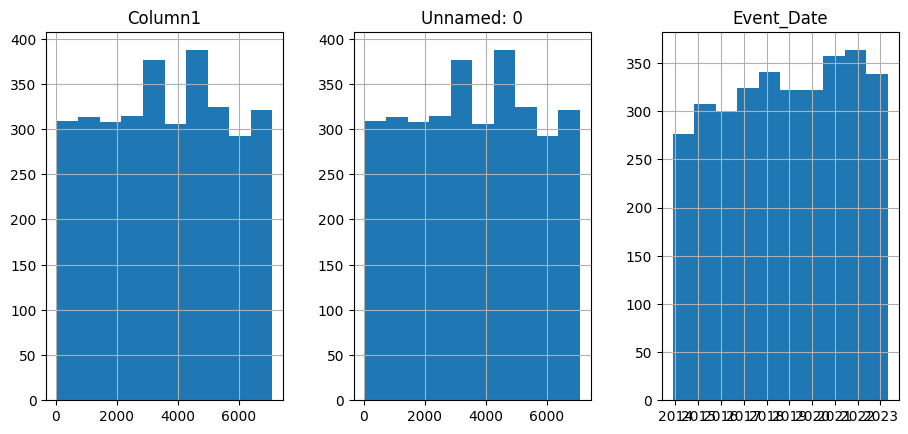

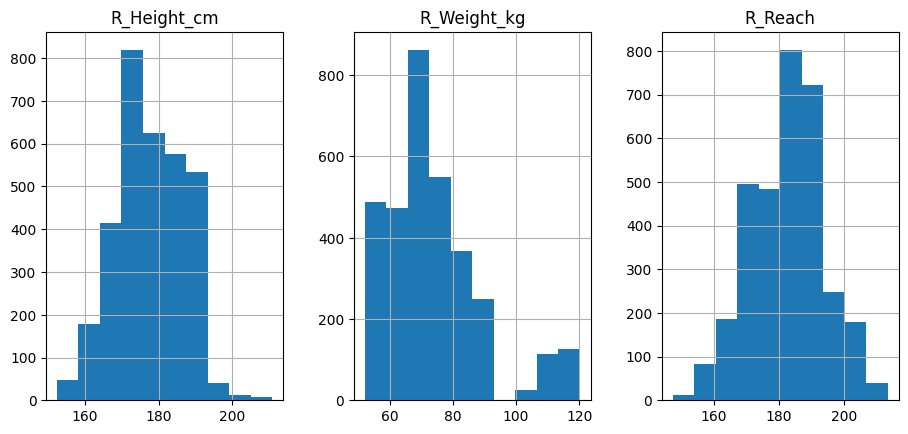

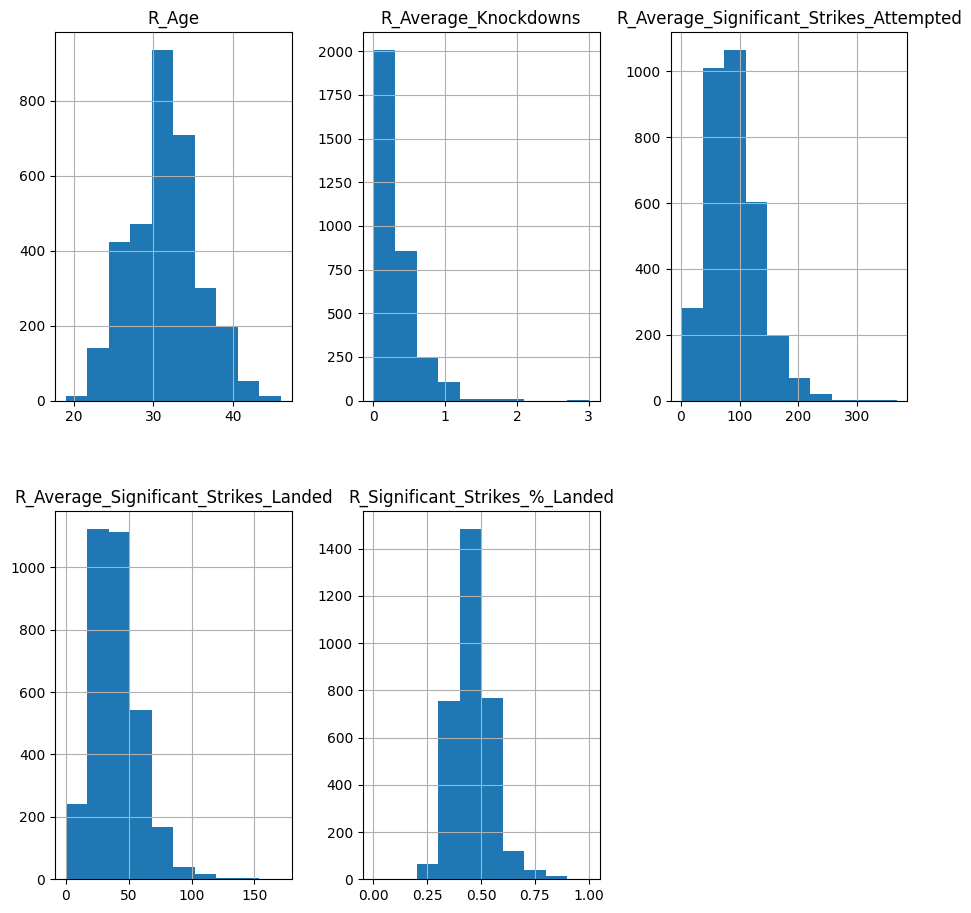

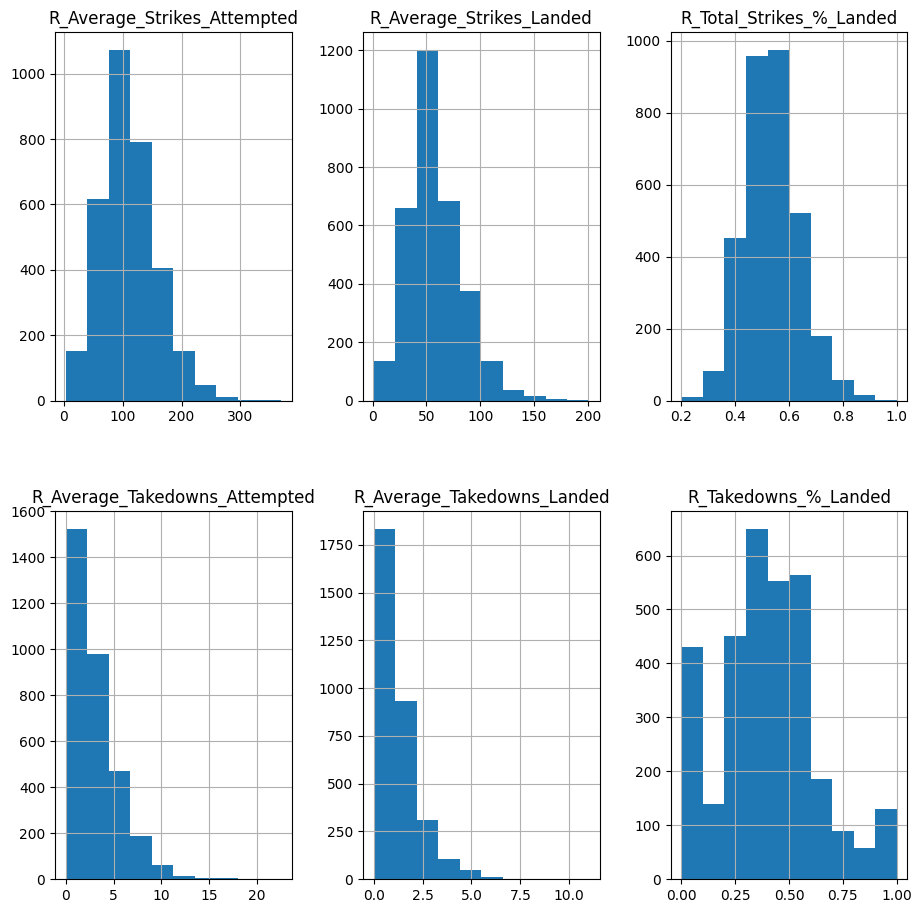

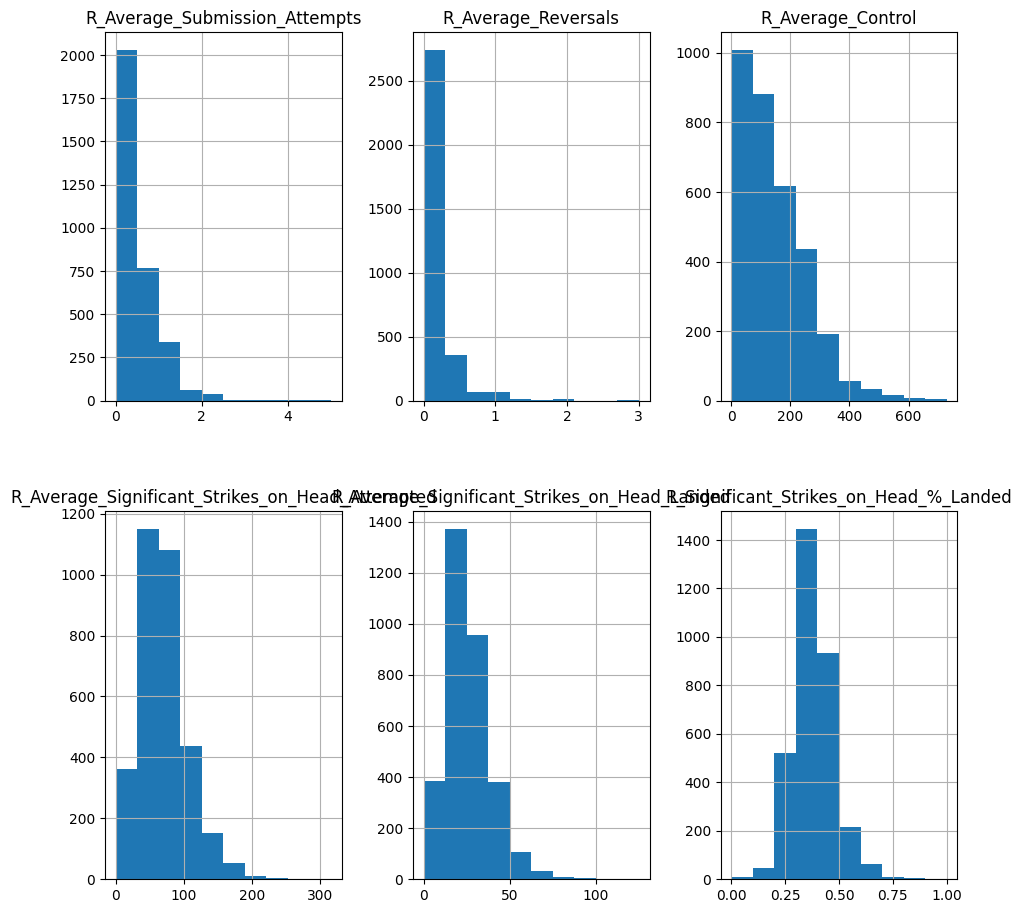

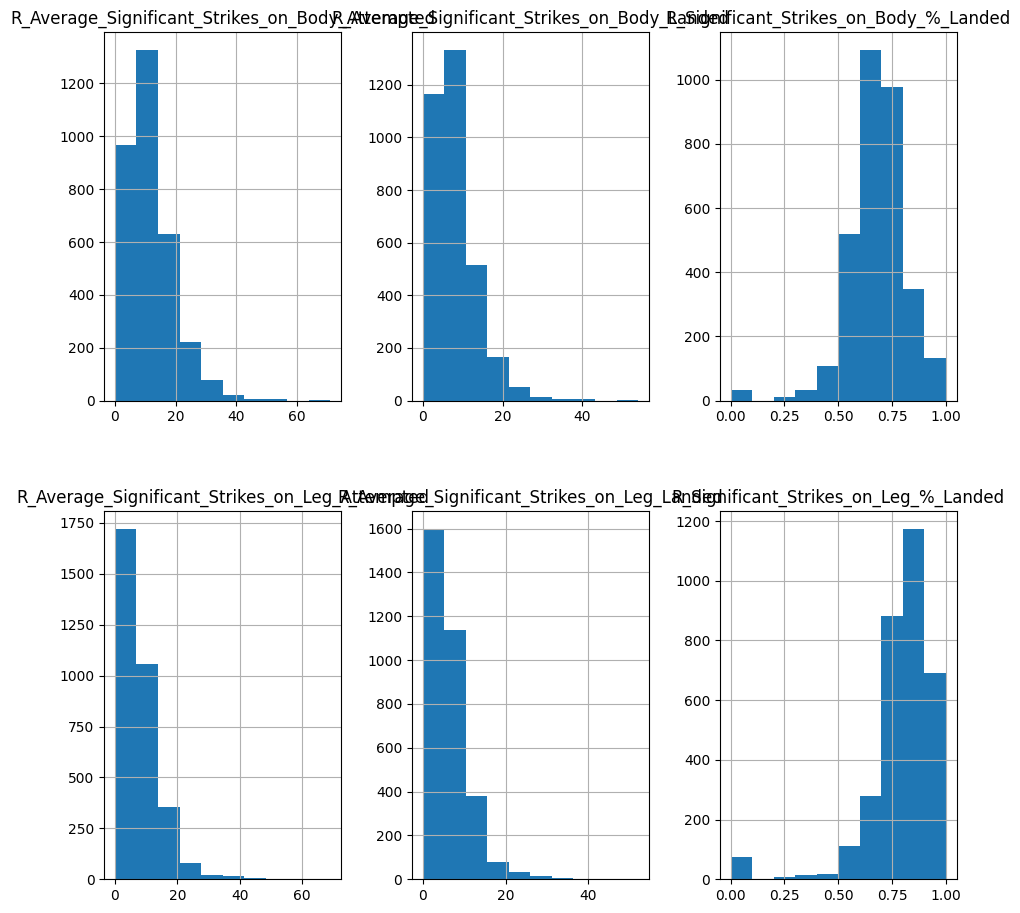

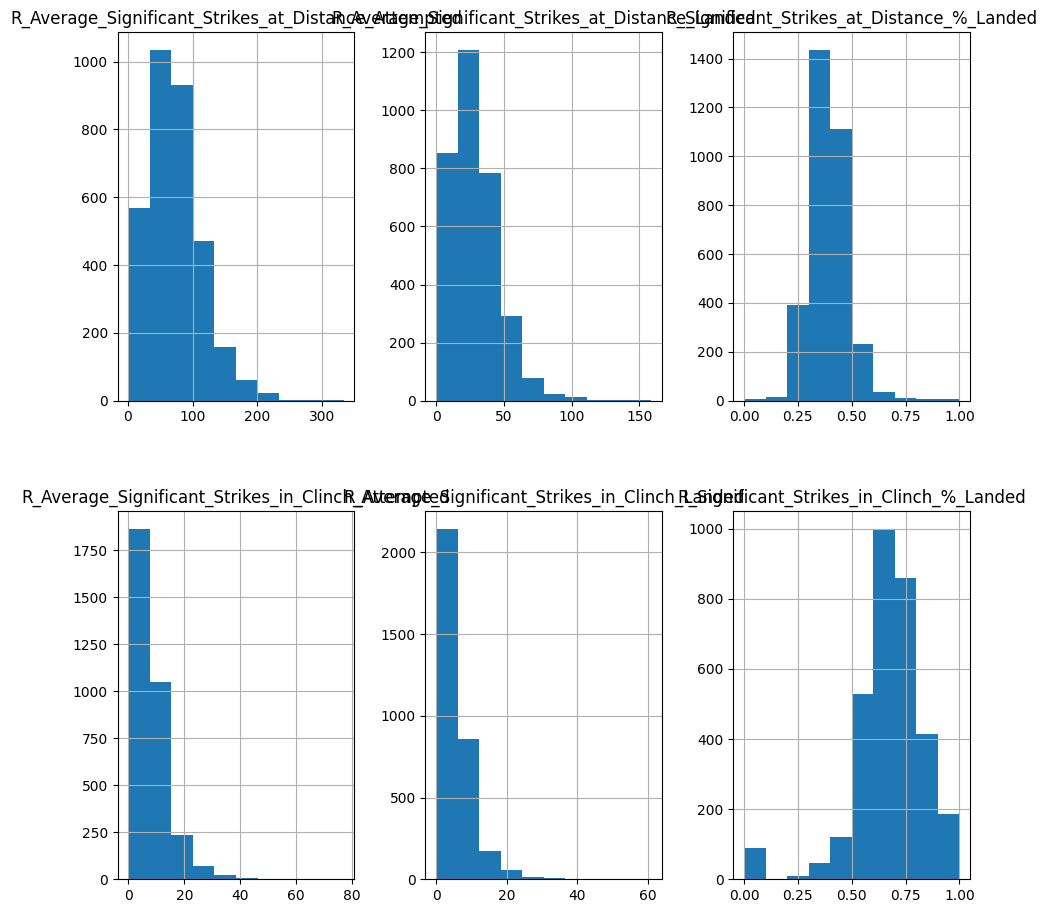

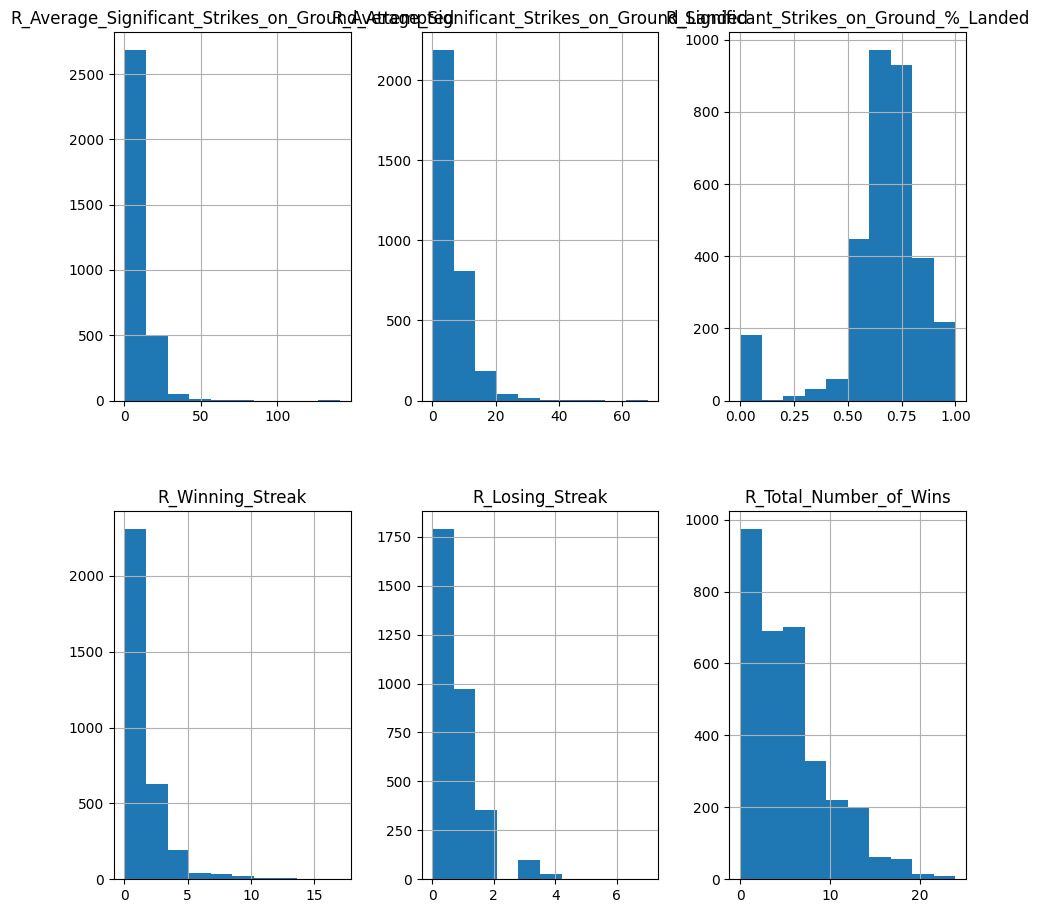

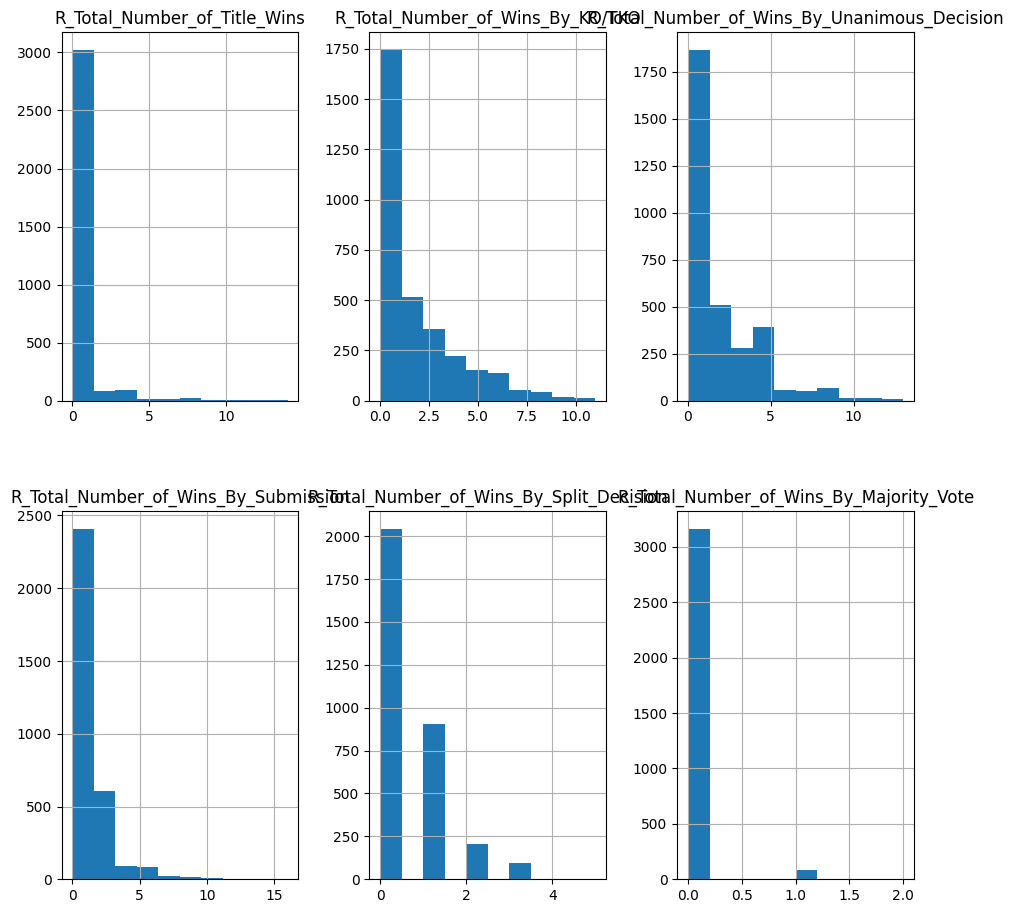

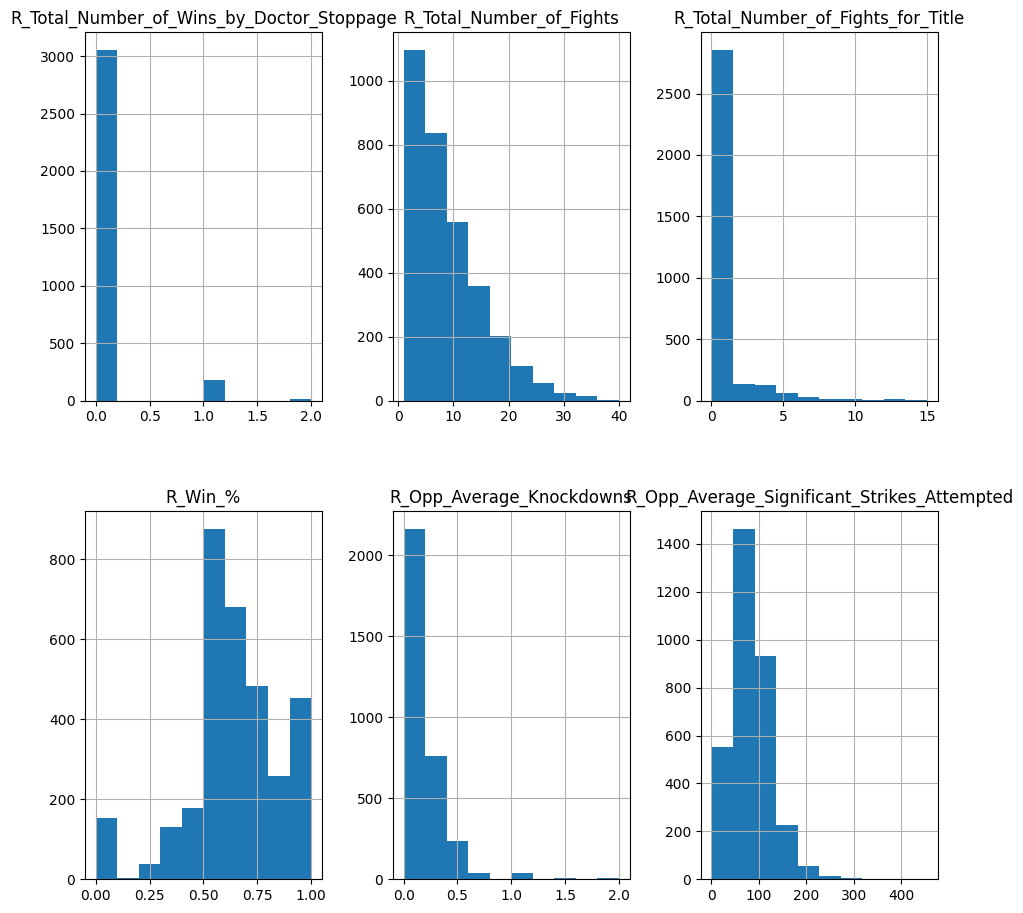

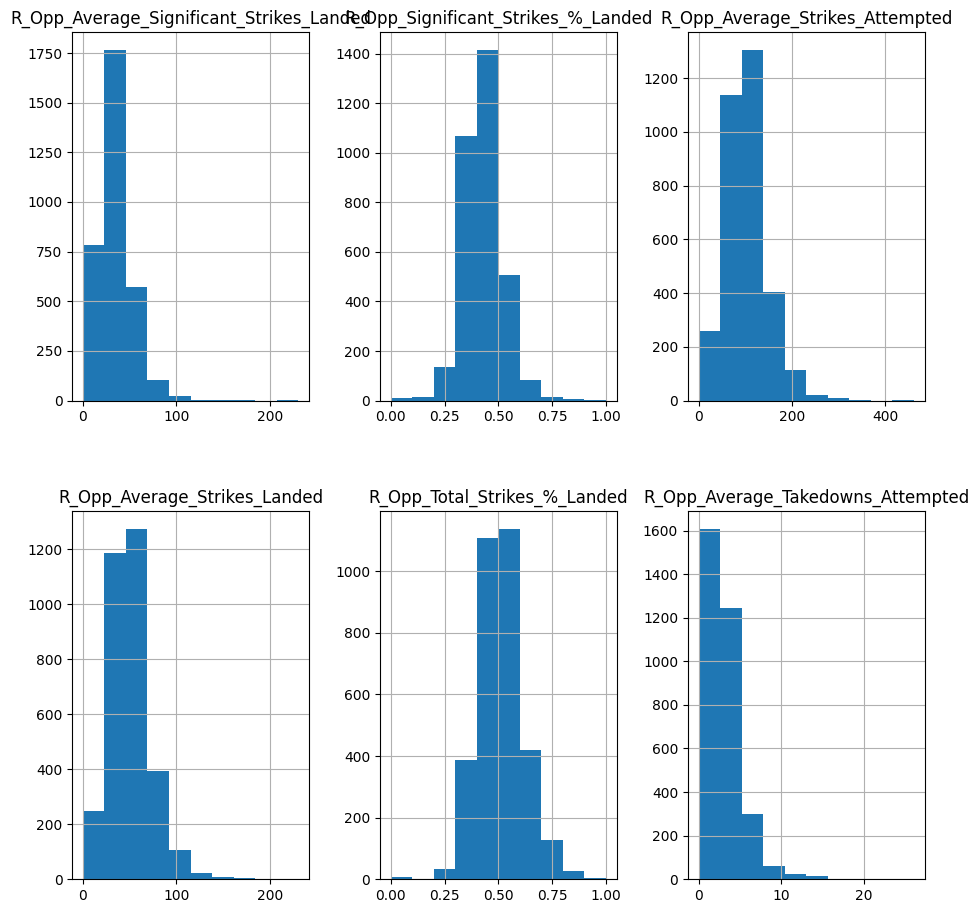

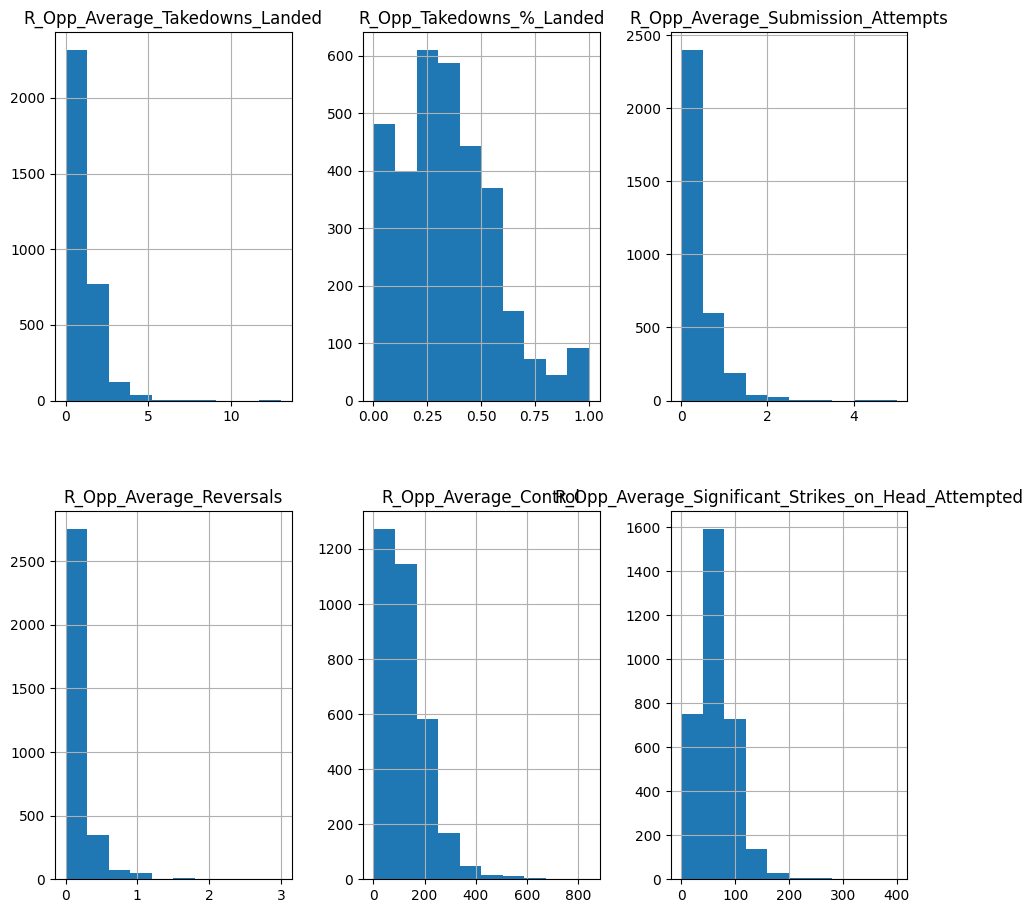

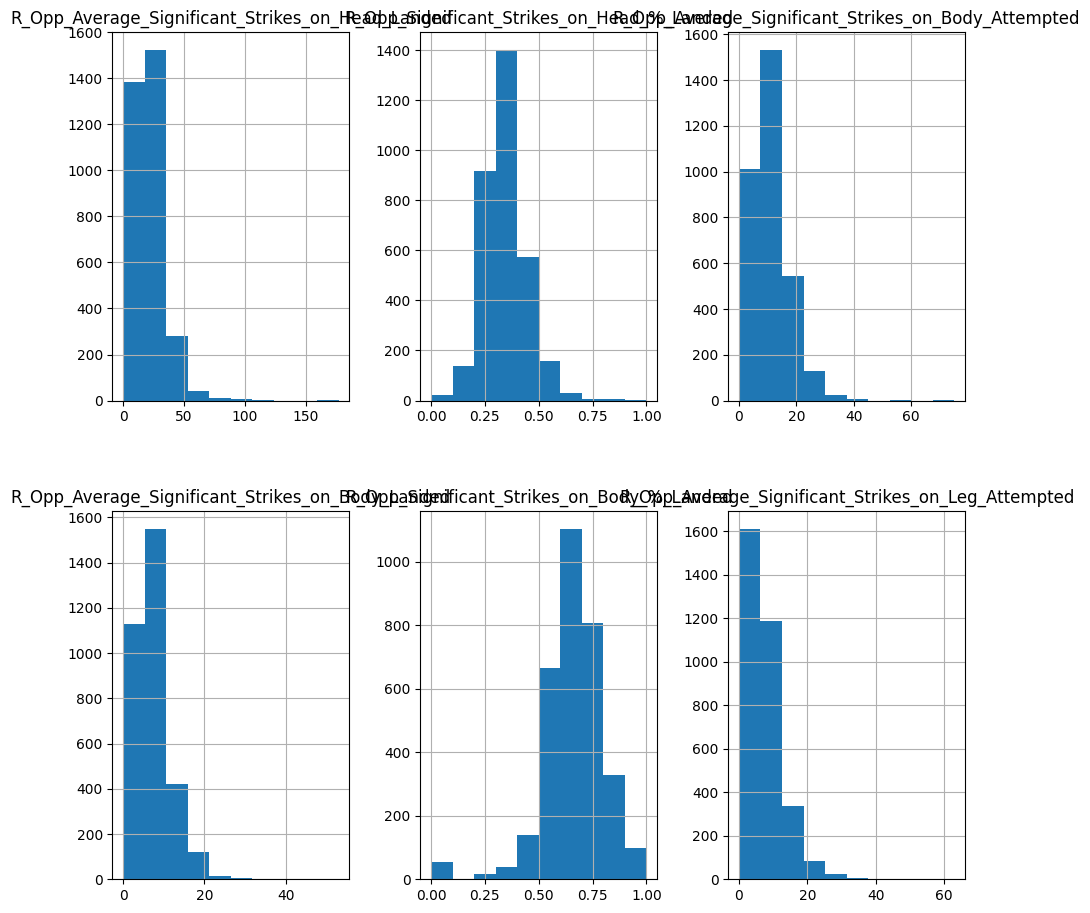

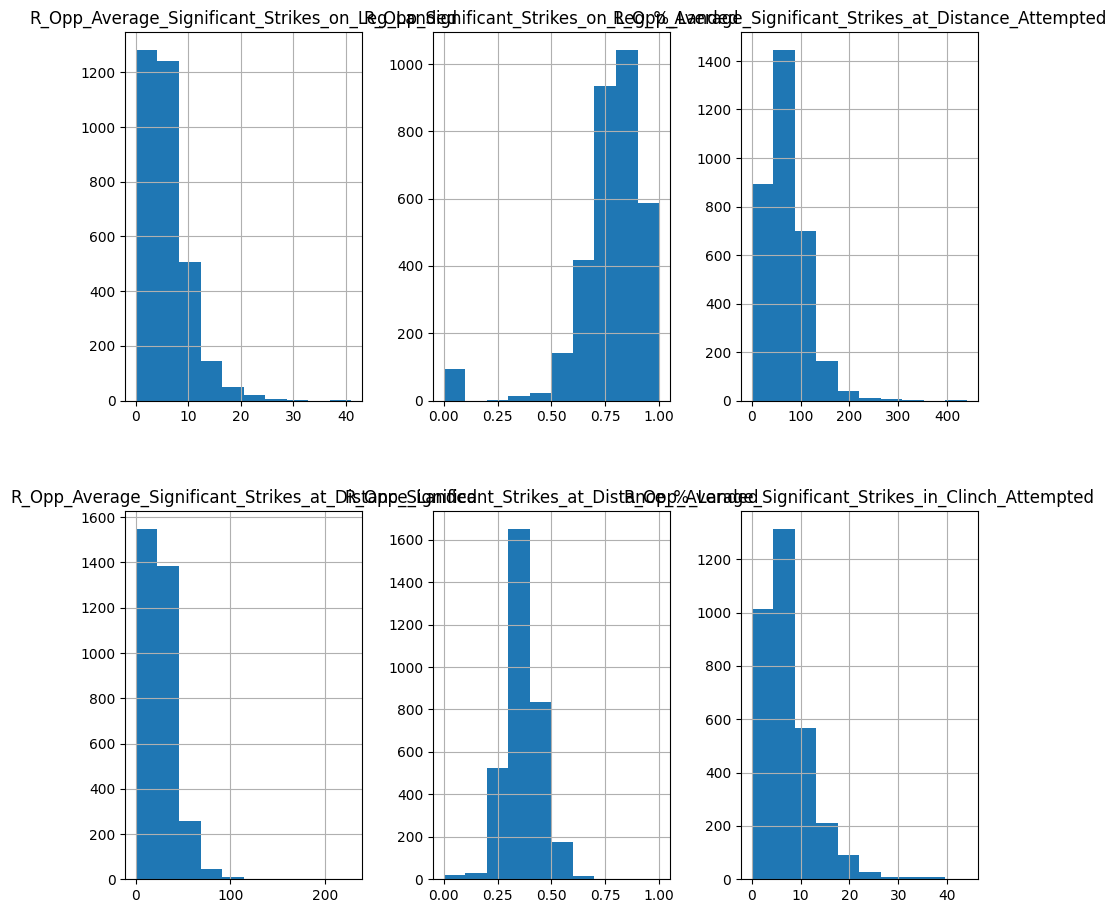

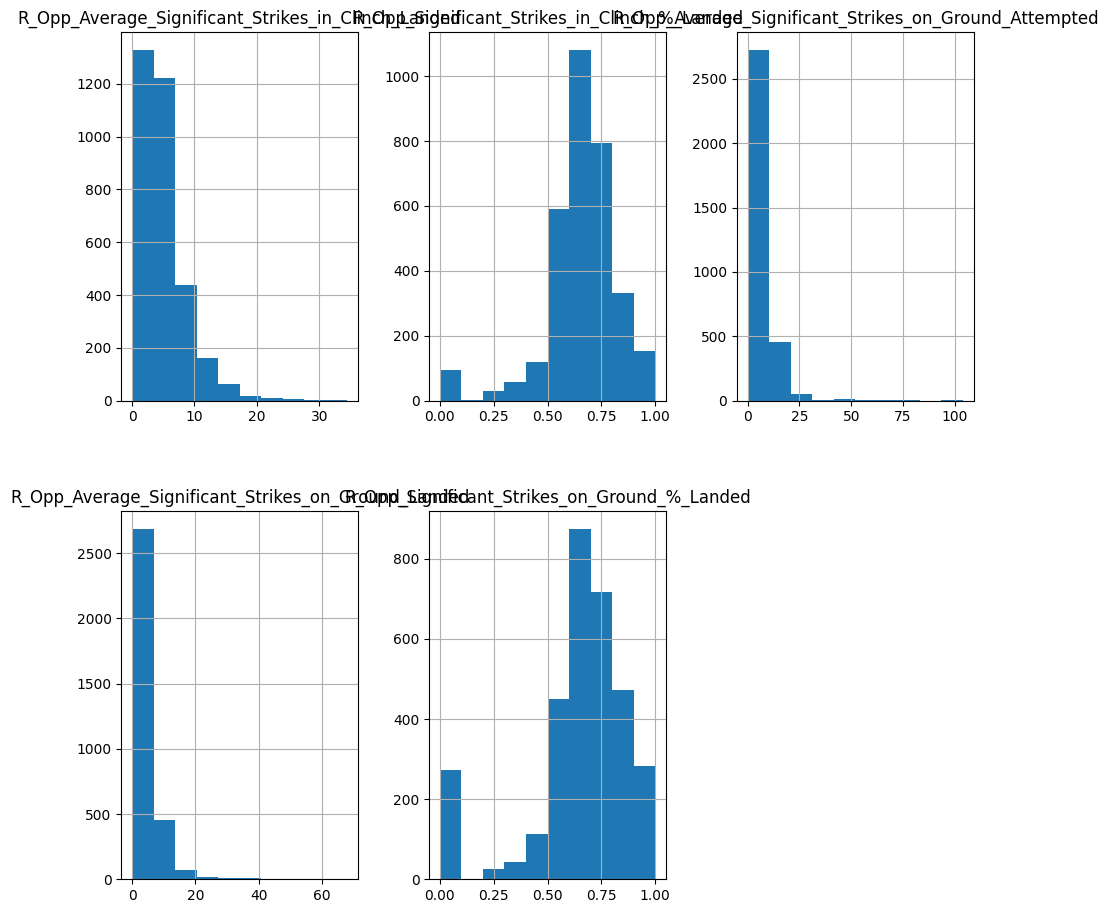

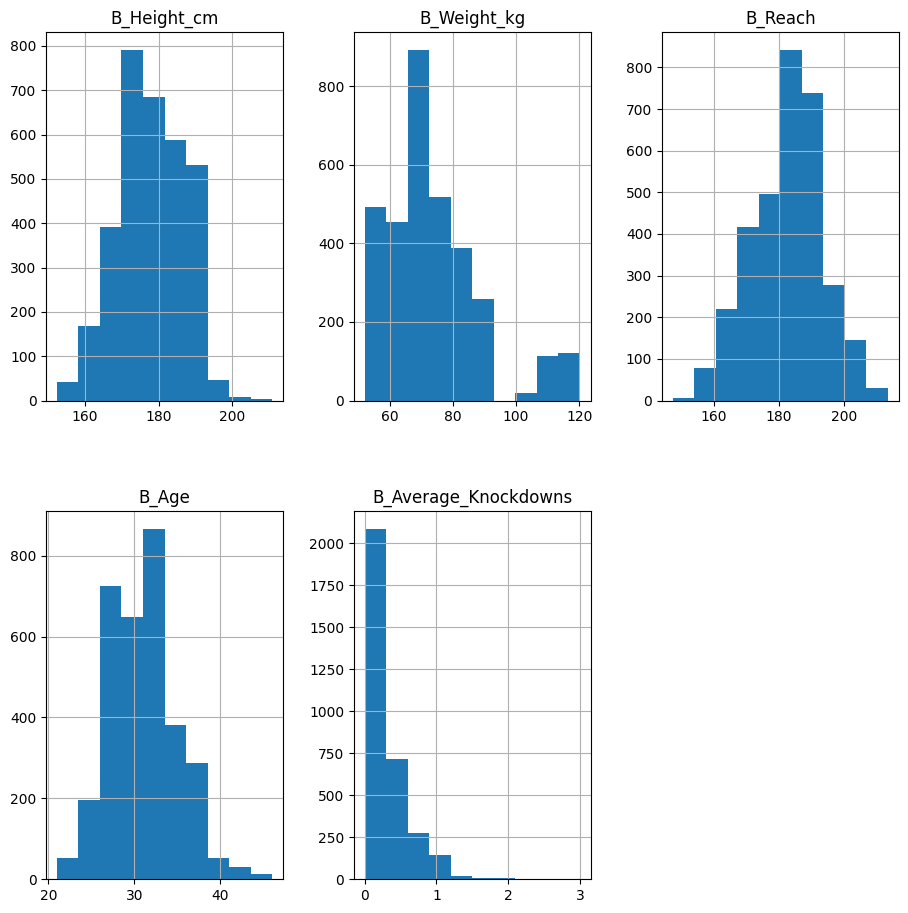

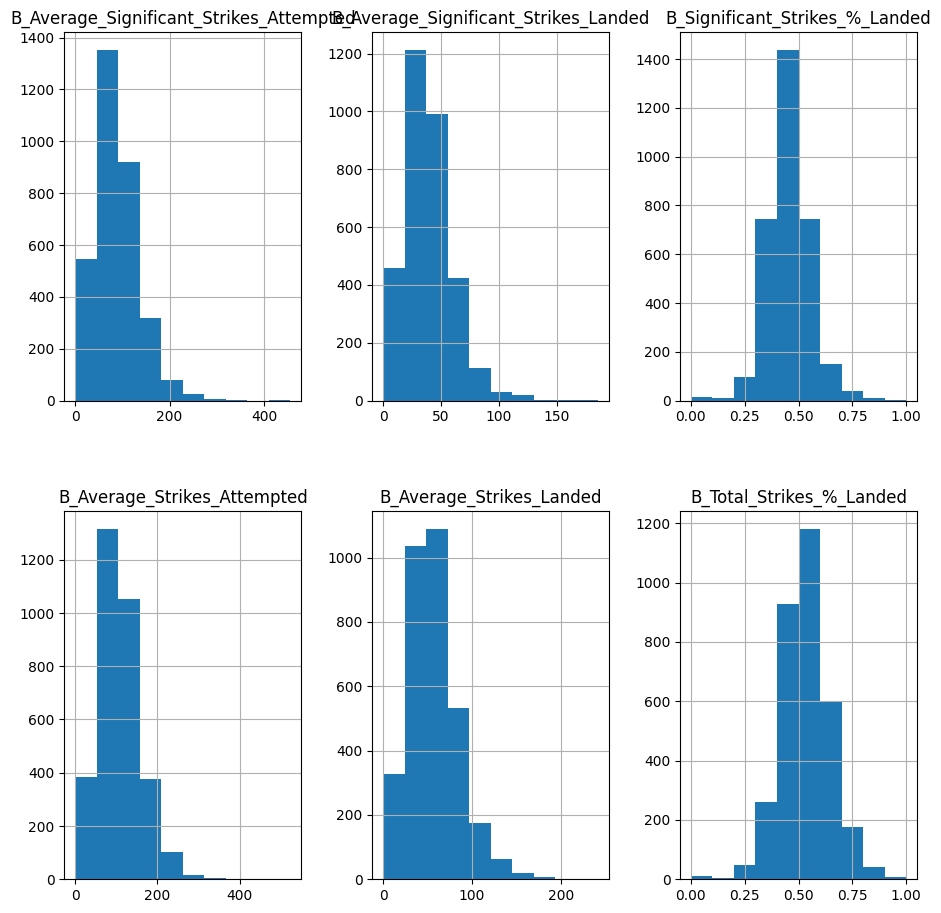

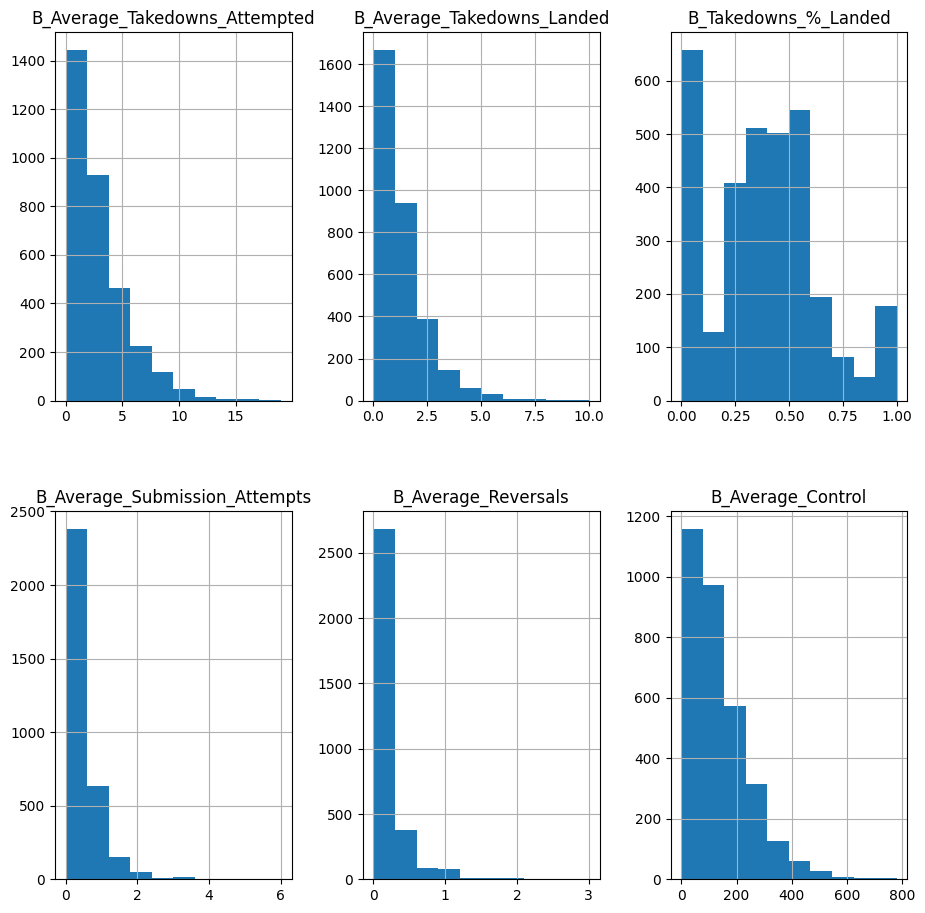

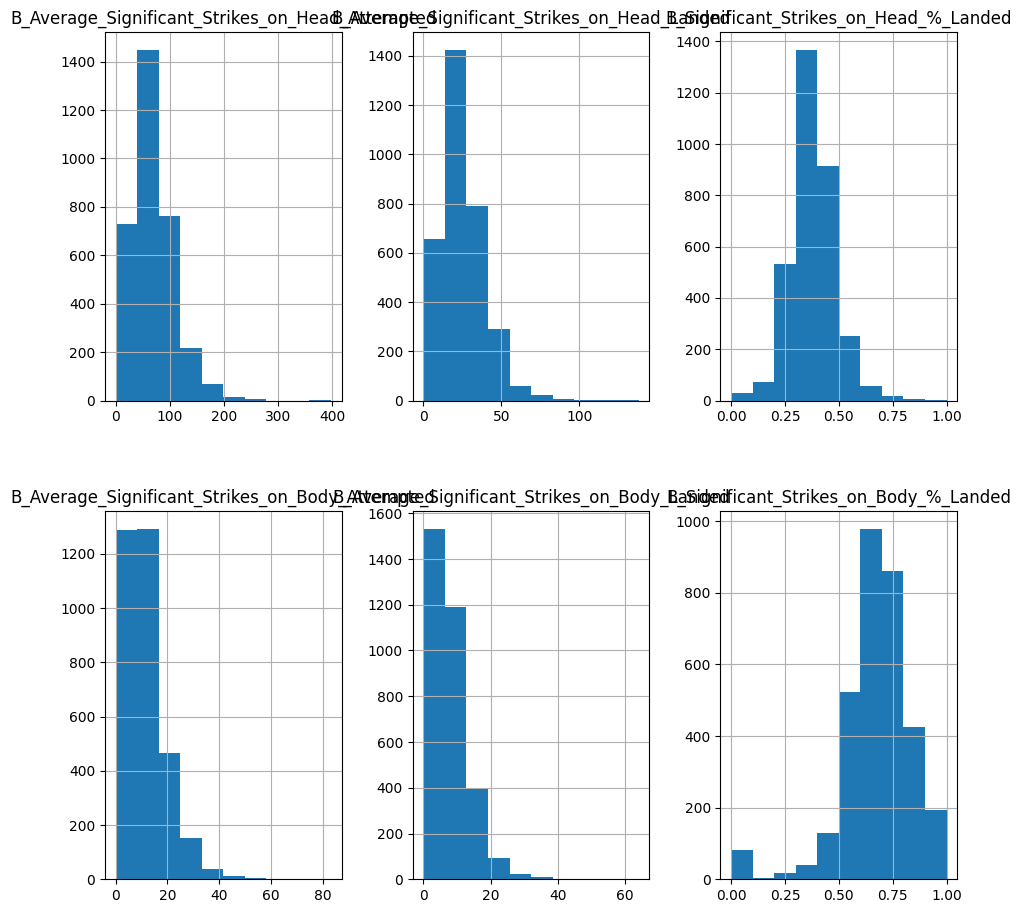

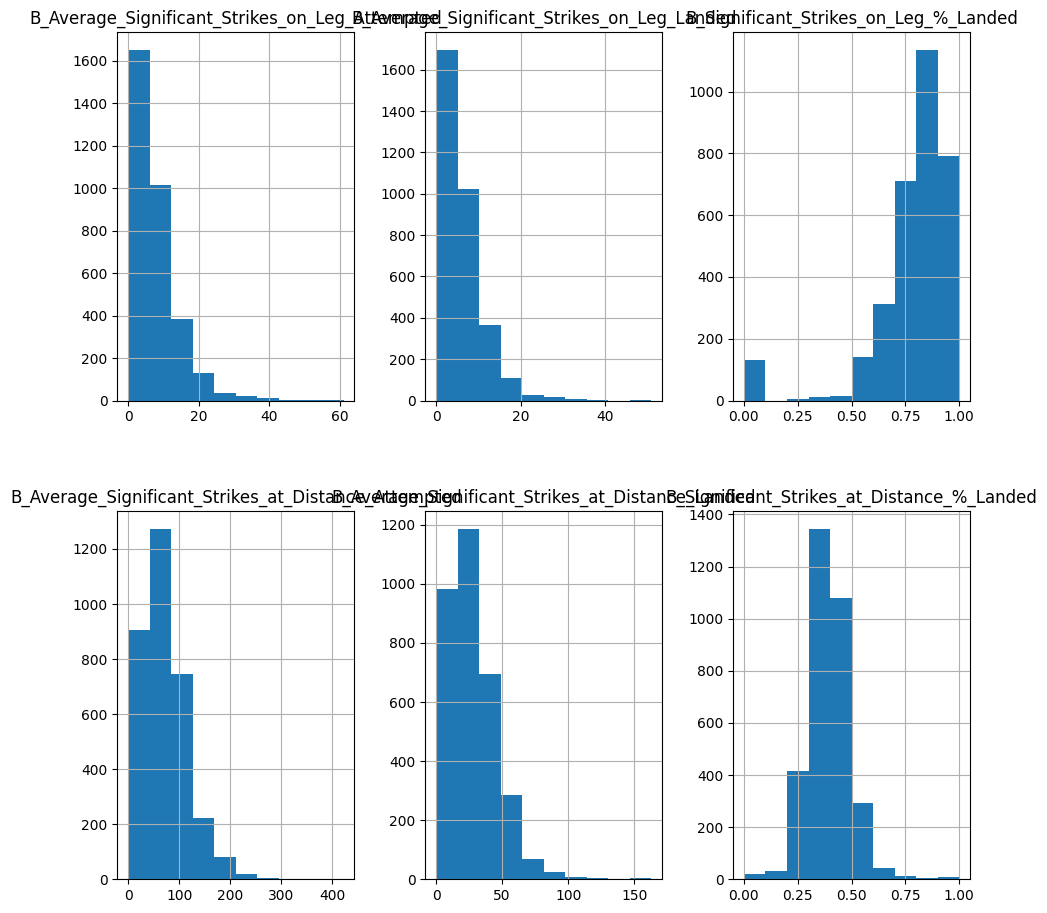

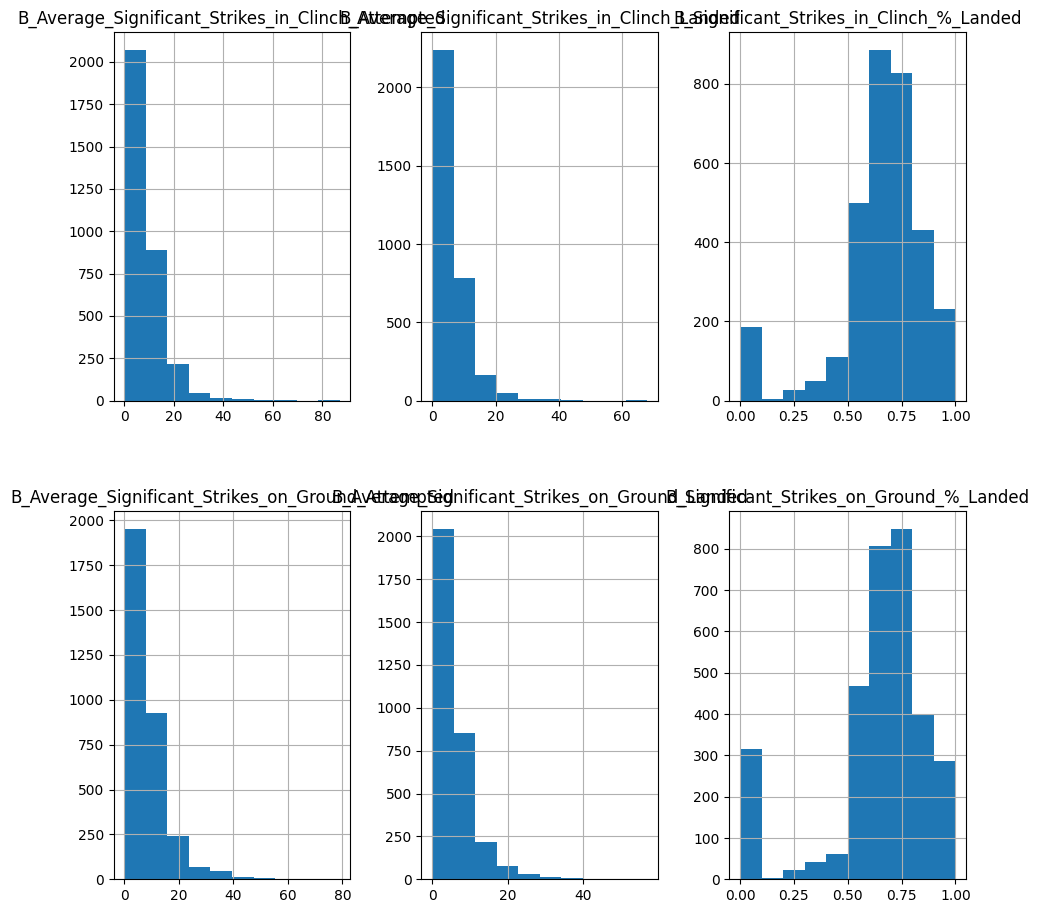

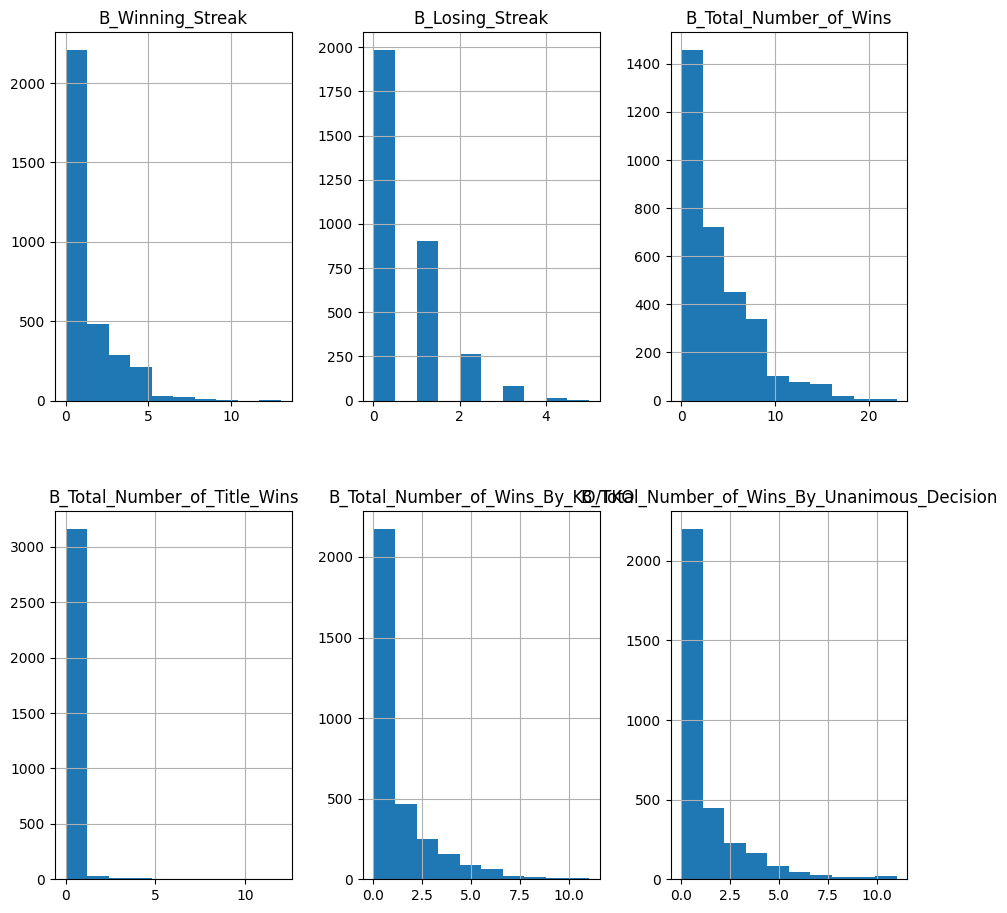

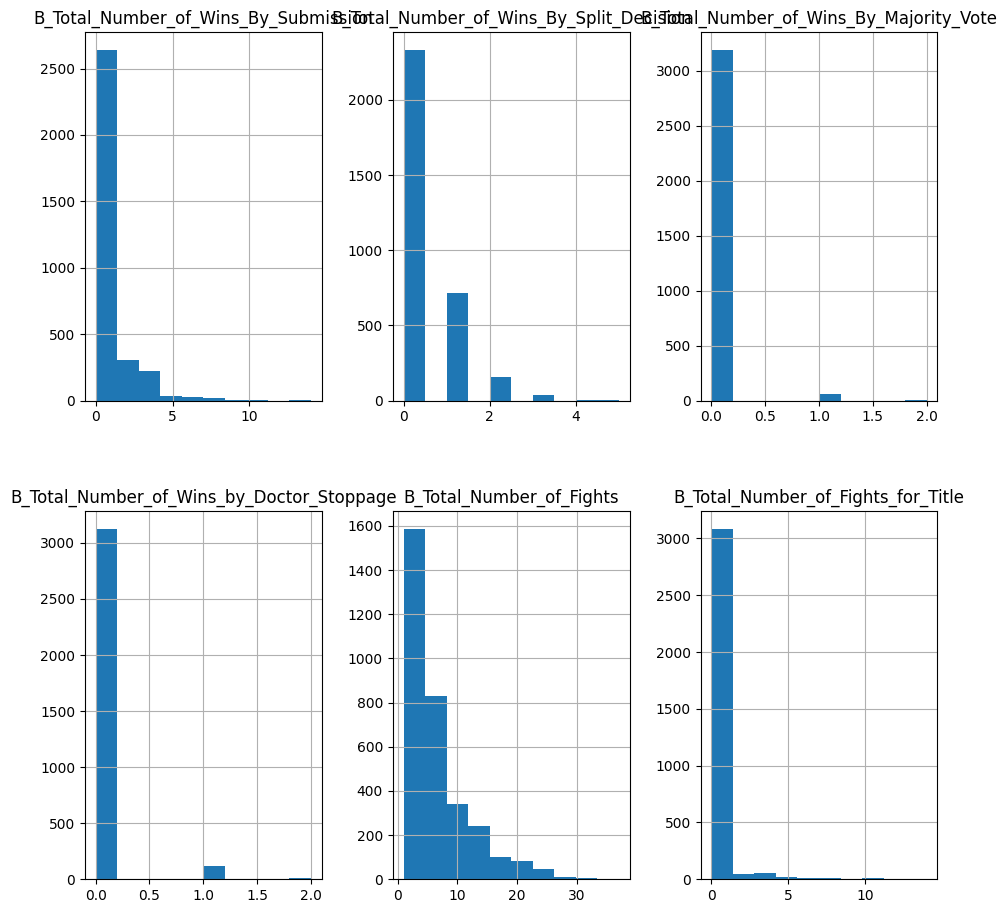

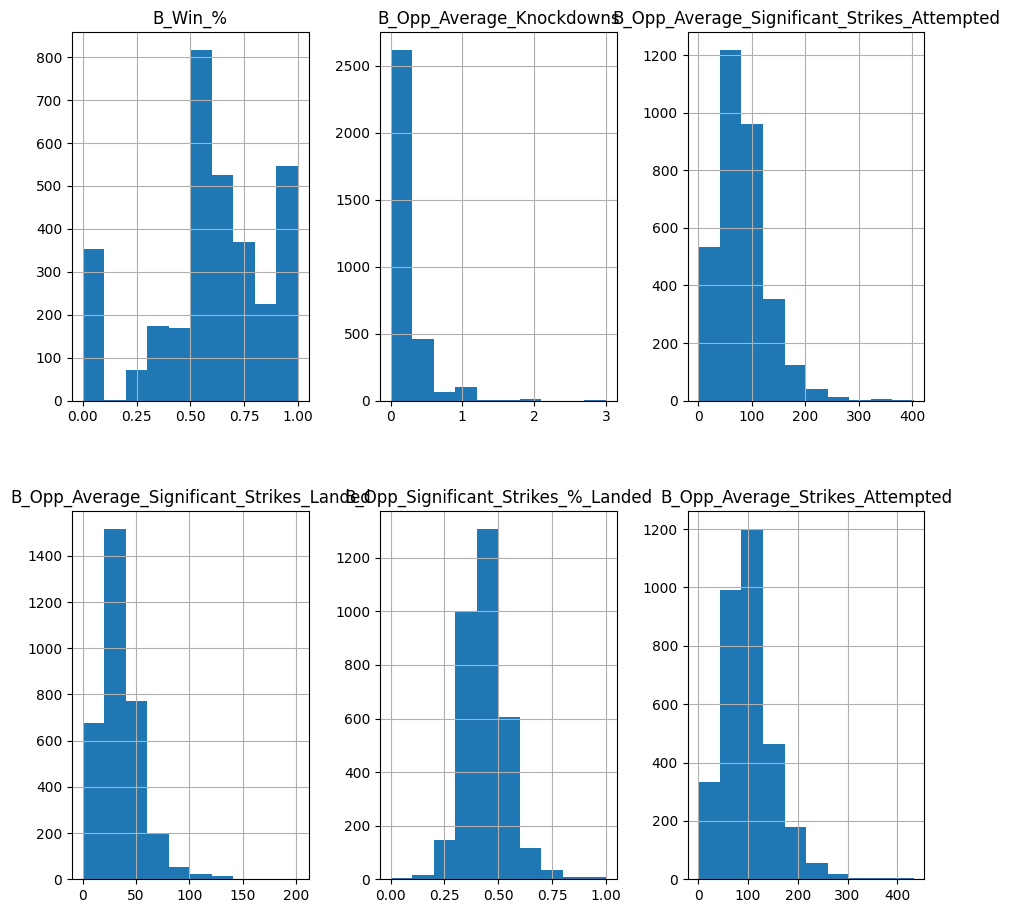

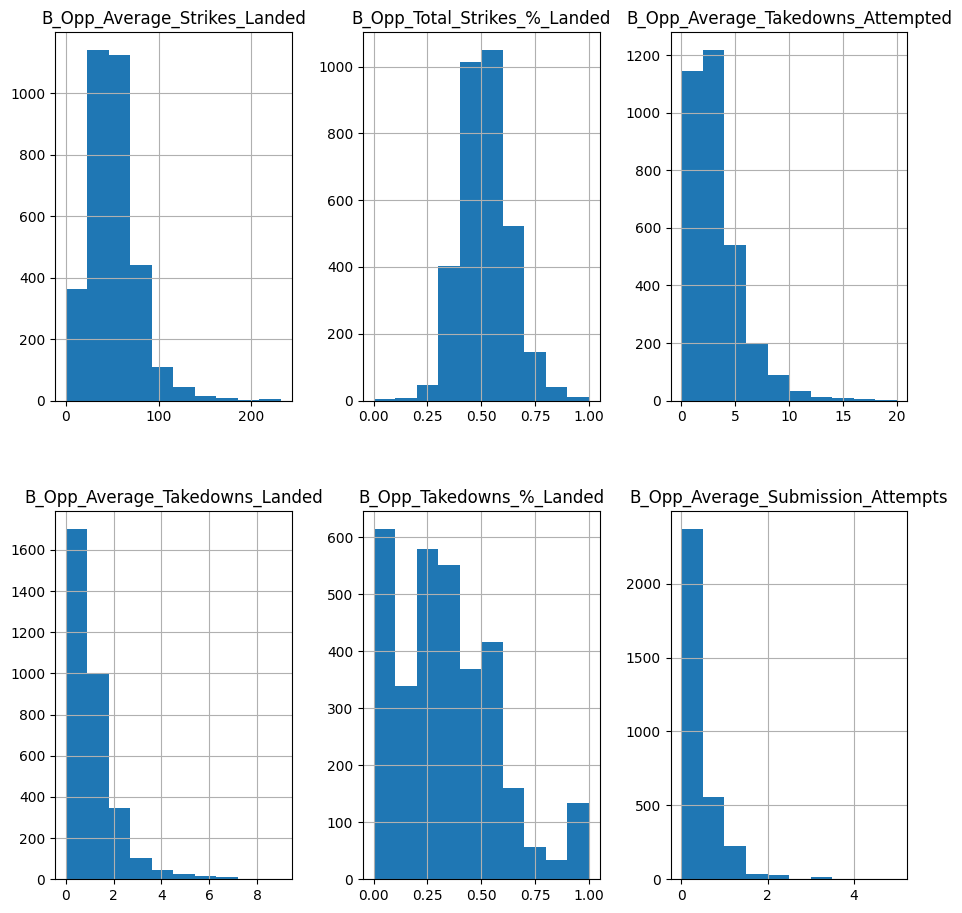

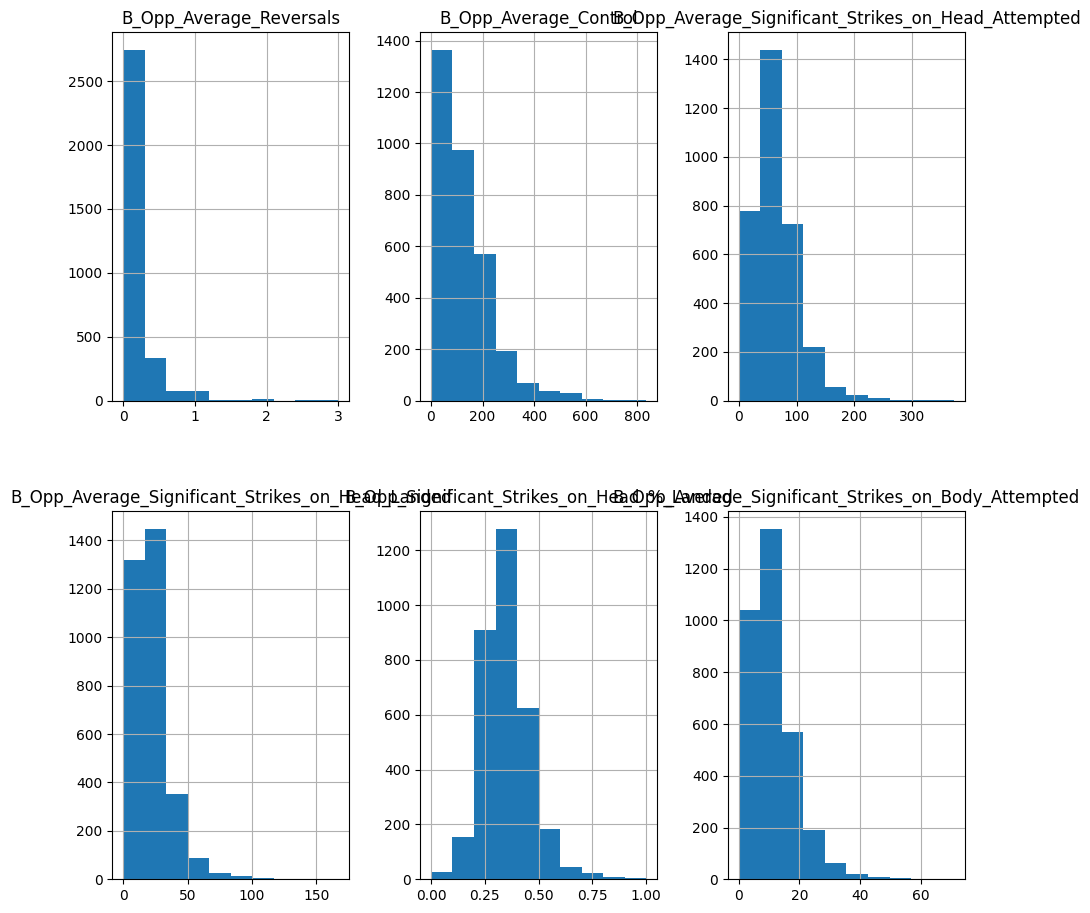

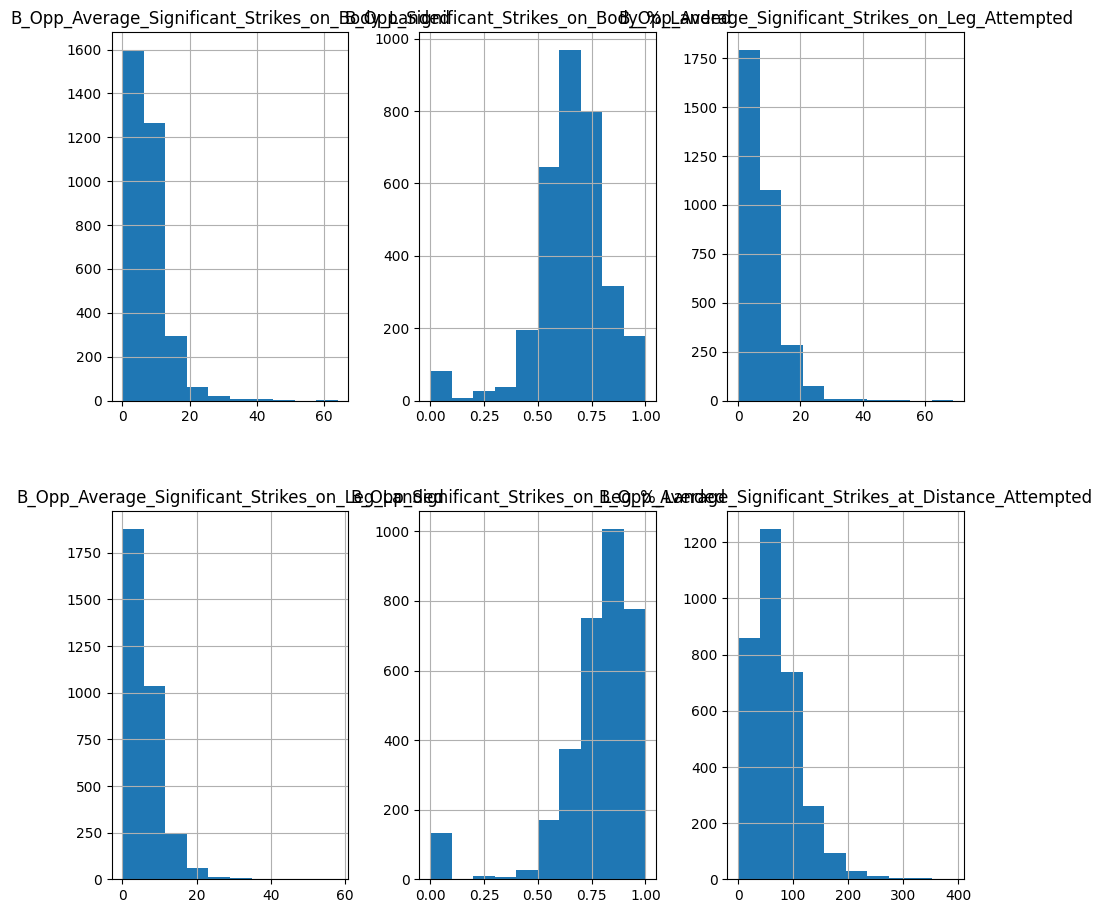

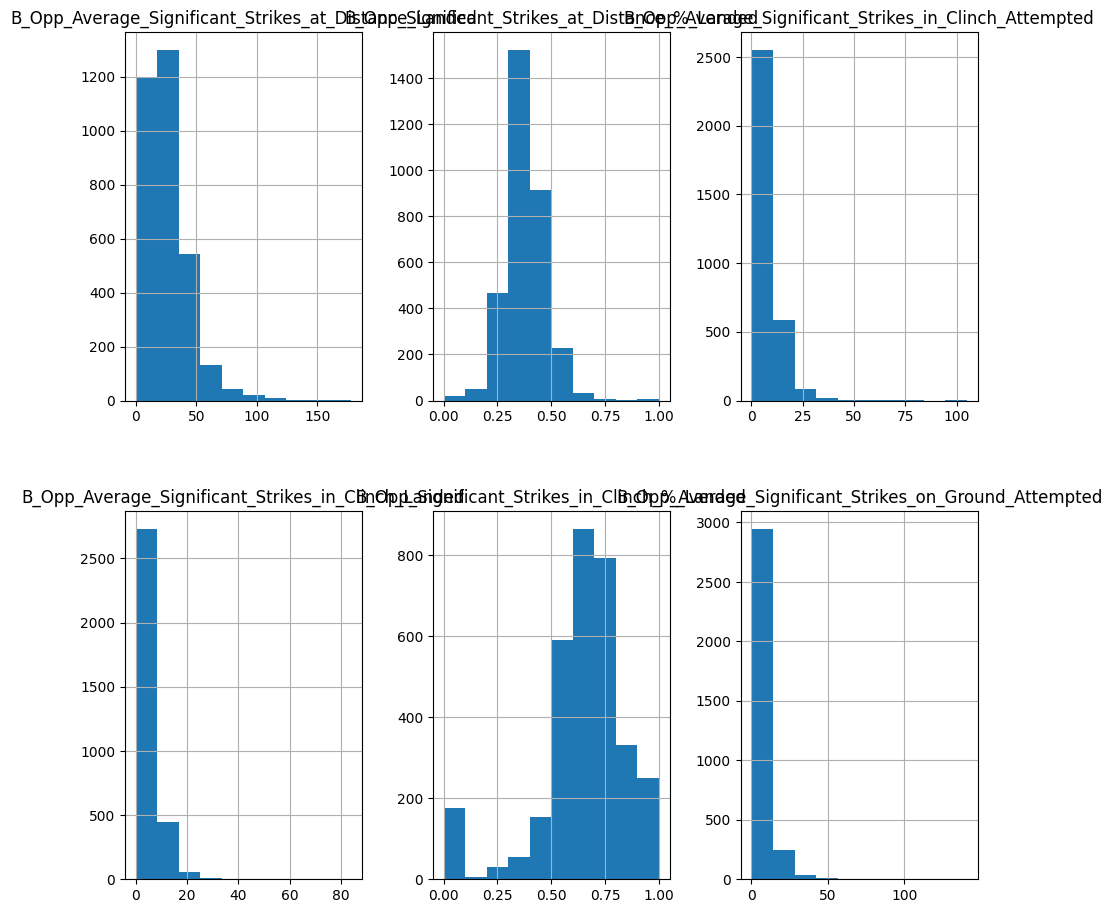

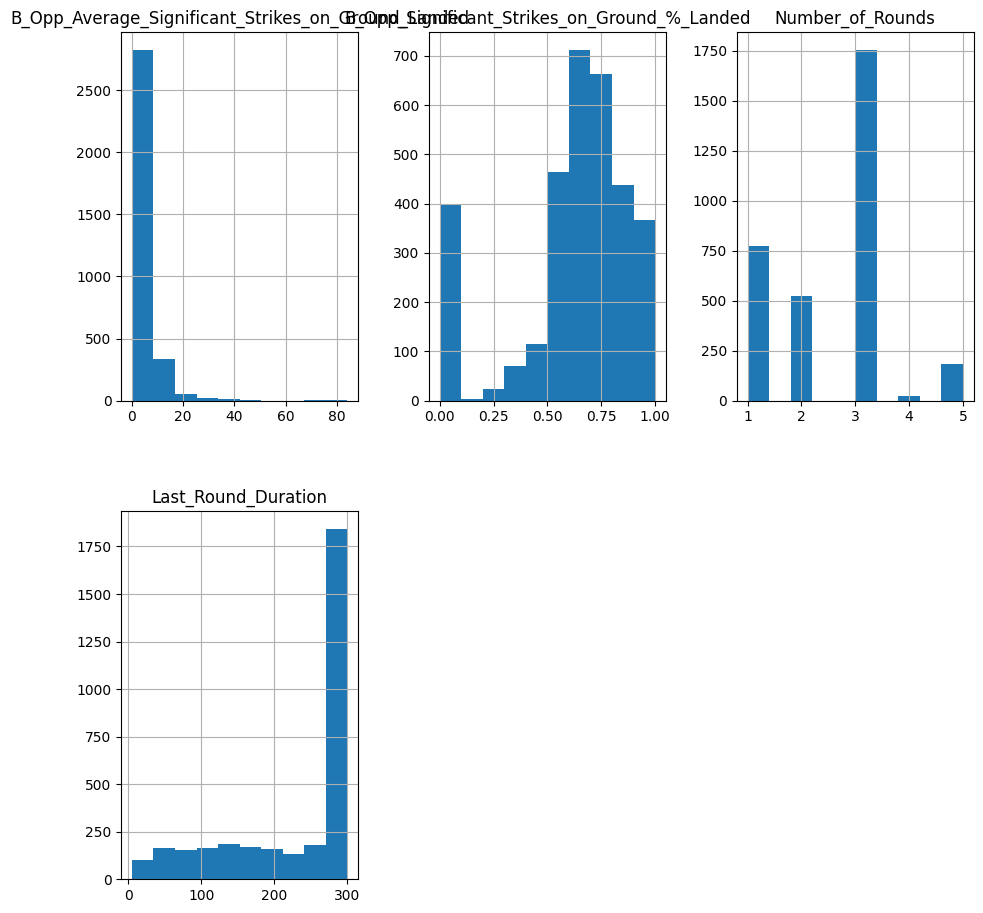

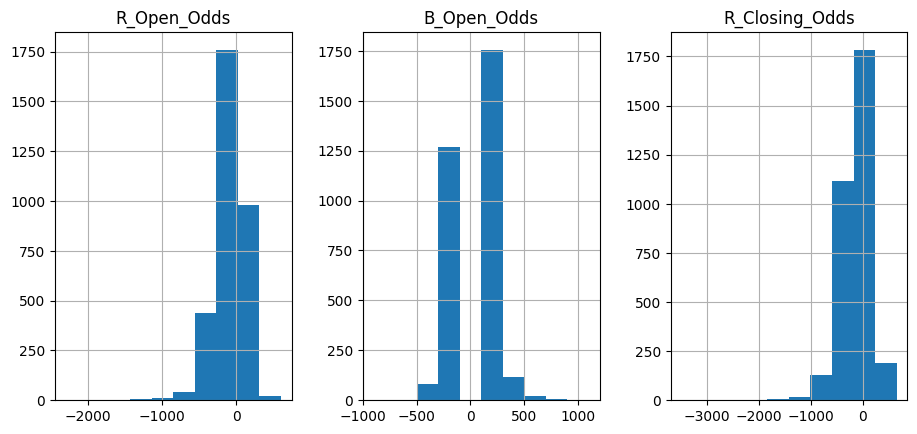

In [23]:
naive_classifier = data.loc[data['Winner'] == 'Red']['Winner'].count() / data['Winner'].count()
print("The naive classifier accuracy is: ", naive_classifier)

feature_dist(data)

It will be quite hard to beat, hence it explains the need to re-run the scraper to obtain more recent data about the fights, since the naive classifier will drop significantly to a little bit over 56%.


We further need to drop some of the columns that will not be of use. I'll also remove closing odds since these will surely improve the model accuracy, but we shouldn't rely on them too much


In [9]:
dropdata = data.drop(['Column1',
                      'Unnamed: 0',
                      'Event_Name',
                      'Event_Location',
                      'B_Name',
                      'R_Name',
                      'Conclusion_Method',
                      'Event_Date',
                      'Last_Round_Duration',
                      'Number_of_Rounds',
                      'Referee',
                      'R_Closing_Odds', # bye bye closing odds...
                      'B_Closing_Odds'], axis=1)

indices = []
i = 0
for _, row in dropdata.iterrows():
    if row['Time_Format'] == '3 Rnd + OT (5-5-5-5)':
        indices.append(i)
        print(i)
    i += 1
    
dropdata.iloc[indices,:].head()


1160


,Fight_Weight,Fight_Title_Bout,Fight_Gender,R_Height_cm,R_Weight_kg,R_Reach,R_Stance,R_Age,R_Average_Knockdowns,R_Average_Significant_Strikes_Attempted,...,B_Opp_Average_Significant_Strikes_in_Clinch_Landed,B_Opp_Significant_Strikes_in_Clinch_%_Landed,B_Opp_Average_Significant_Strikes_on_Ground_Attempted,B_Opp_Average_Significant_Strikes_on_Ground_Landed,B_Opp_Significant_Strikes_on_Ground_%_Landed,Time_Format,Winner,Underdog,R_Open_Odds,B_Open_Odds
4222,Welterweight,True,Male,187.96,77.097506,190.5,Orthodox,28.0,0.0,46.75,...,3.0,1.0,2.0,1.0,0.5,3 Rnd + OT (5-5-5-5),Blue,No one,185.0,-265.0


Next, let's find numerical and categorical columns in our dataset. 

In [30]:
objecttypes_cat = list(dropdata.select_dtypes(include=['O']).columns)
objecttypes_num = list(dropdata.select_dtypes(include=['int64', 'float64']).columns)

objecttypes_cat = [x for x in objecttypes_cat if x != 'Winner']

# for col in objecttypes:
#     dropdata[col] = dropdata[col].astype('category')
    

['Fight_Weight', 'Fight_Gender', 'R_Stance', 'B_Stance', 'Time_Format', 'Underdog']


## Data correlation

Since we are givem a considerate number of features, instead of presenting all possible correlations, we'll stick to N most significant ones.


In [ ]:
# Basic Correlation Matrix
# corrmat = data.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# seaborn.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
# # Subset Correlation Matrix
# k = 10 #number of variables for heatmap
# corrmat = dropdata.corr()
# cols = corrmat.nlargest(k, 'Winner')['Winner'].index
# cm = np.corrcoef(dropdata[cols].values.T)
# seaborn.set(font_scale=1.25)
# hm = seaborn.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

# Candidate models

We've chosen the following candidate models that we will further try to get the best performance from. In the end, we will present a comparison of each model.

#### - Perceptron
#### - Random Forests
#### - Decision Trees Classifier
#### - SGD Classifier
#### - Linear SVC
#### - Gaussian Naive Bayes
#### - KNN


In [18]:
tuned_models = dict()

### Standardizing the data (based on X_train):

In [27]:
# Set the random seed
random.seed(2137)
np.random.seed(2137)

Y_all = dropdata['Winner']
X_all = dropdata.drop(['Winner'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.25, random_state=2023)

# standardizer for numerical columns
transformer_num = Pipeline([
    ('scaler', StandardScaler())
])

# standardizer for categorical columns
transformer_cat = Pipeline([
    ('scaler', OneHotEncoder())
])

# jumping into using these into the preprocessor for all features:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', transformer_num, objecttypes_num),
        ('cat', transformer_cat, objecttypes_cat)   # no 'Winner' encoded
], remainder='passthrough')

# the standardization should be based on the training set, hence we obtain the relevant parameters:
preprocessor.fit_transform(X_train)

array([[-1.74557471, -1.1912487 , -1.18619988, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.4842861 ,  0.08559447,  0.4163749 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.74557471, -1.1912487 , -1.64407839, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.46684211, -0.90750577, -1.41513914, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7630187 ,  1.07869472,  1.56107118, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.3204839 ,  1.07869472,  0.87425341, ...,  1.        ,
         0.        ,  0.        ]])

## Perceptron:

The Perceptron is another simple classification algorithm suitable for large scale learning. By default:

        It does not require a learning rate.

        It is not regularized (penalized).

        It updates its model only on mistakes.

The last characteristic implies that the Perceptron is slightly faster to train than SGD with the hinge loss and that the resulting models are sparser.

- Linearly separable

In [29]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', Perceptron(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 20, 30, 50, 70, 90],
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],
    'model__max_iter': [100, 150, 200, 250],
    'model__tol': [1, 0.1, 0.01, 0.001]
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=3, verbose=2)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits


KeyboardInterrupt: 

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_perceptron_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_perceptron_model.pkl', 'rb') as f:
    model = pickle.load(f)

print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Perceptron'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

# store model results in tuned_models dictionary

tuned_models['Perceptron'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Random Forest Classifier

A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', RandomForestClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 20, 30, 50, 70, 90],
    'model__n_estimators': [50, 100, 200, 300],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [10, 30, 60, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=4)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_random_forest_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ', acc_sco)
tuned_models['Random_Forest'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Decision Tree Classifier

A decision tree classifier.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', DecisionTreeClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [3, 5, 10, 20, 50],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [2, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': ['sqrt', 'log2']
}

# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=3)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_decision_tree_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_decision_tree_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Decision_Tree'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Stochastic Gradient Descent (SGD) Classifier

A linear classifier with SGD training. Default implementation uses the loss='hinge' used for linear SVM

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', SGDClassifier(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 20, 40, 60],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__max_iter': [100, 200, 300],
    'model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_SGDClassfier_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_SGDClassfier_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['SGDClassfier'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Linear SVC

Linear Support Vector Classification.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', LinearSVC(random_state=2023))
])


# Define the parameter grid
param_grid = {
    'selector__k': [40, 60, 70, 80],
    'model__loss': ['hinge', 'squared_hinge'],
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [100, 200, 300],
    'model__tol': [0.1, 0.01, 0.001, 0.0001, 0.00001]
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_LinearSVC_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_LinearSVC_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['LinearSVC'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## Gaussian Naive Bayes

Gaussian Naive Bayes (GaussianNB)

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', GaussianNB())
])


# Define the parameter grid
param_grid = {
    'selector__k': [2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90],
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_GaussianNB_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_GaussianNB_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['Gaussian_NB'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

## KNN

Classifier implementing the k-nearest neighbors vote.

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest()),
    ('model', KNeighborsClassifier())
])


# Define the parameter grid
param_grid = {
    'selector__k': [5, 10, 20, 40, 60],
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, Y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, Y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_KNN_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

In [ ]:
# load the best model from disk using pickle
with open('best_KNN_model.pkl', 'rb') as f:
    model = pickle.load(f)
 
print('Best parameters after the grid search: ', model.best_params_)

In [ ]:
# printing the initial, preprocessed columns:
print('Columns in X_train: ', preprocessor.get_feature_names_out())

# Get the selected feature indices after SelectKBest() in the best estimator
selected_feature_indices = model.best_estimator_.named_steps['selector'].get_support(indices=True)

# Get the column names of the selected features
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
print('\nColumns after feature selection: ', selected_feature_names)

In [ ]:
# storing accuracy score:
acc_sco = accuracy_score(Y_test, model.predict(X_test)) 

# construction confusion matrix
cm = conf_mat(model, Y_test)

# store model results in tuned_models dictionary

print('Accuracy on the test set: ',acc_sco)
tuned_models['KNN'] = {'accuracy': acc_sco, 'model': model, 'confusion_matrix': cm}

# FINAL TUNEL MODELS COMPARISON

Here we assess the performance of each model


In [ ]:
plot_models_acc(tuned_models, naive_classifier)

# NOTES

If the odds are available before the fight, then there is nothing inherently wrong with using them as a predictor. However, it's important to keep in mind that any information used for prediction should be available at the time the prediction is made. If the model is trained on data that includes information (such as odds) that would not be available at the time of prediction, then the model may overfit to the training data and perform poorly on new, unseen data.

Additionally, it's important to consider the ethics of using betting odds for predictive modeling. While it may be legal to use this information for research purposes, it could be seen as promoting gambling or taking advantage of vulnerable populations. It's important to approach this type of research with sensitivity and to consider the potential impacts of the research on society.